In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/deep-learning-from-scratch-2-master')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/deep-learning-from-scratch-2-master/ch06')

### 기울기 소실, 기울기 폭발 문제

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

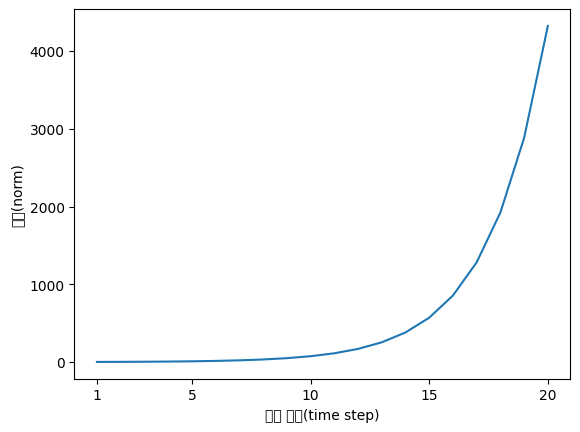

In [3]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) # 재현할 수 있도록 seed 고정
Wh = np.random.rand(H, H)
# Wh = np.random.rand(H,H) * 0.5

norm_list = []
for t in range(T):
  dh = np.matmul(dh, Wh.T)
  norm = np.sqrt(np.sum(dh**2))/N
  norm_list.append(norm)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

### 기울기 클리핑

In [4]:
import numpy as np

dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
  total_norm = 0
  for grad in grads:
    total_norm += np.sum(grad **2 )
  total_norm = np.sqrt(total_norm)

  rate = max_norm / (total_norm + 1e-6)
  if rate < 1:
    for grad in grads:
      grad *= rate

print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [4.40809844 0.29876211 4.56833224 6.49144048 2.78487283 6.76254902
 5.90862817 0.23981882 5.58854088]
after: [1.09648418 0.07431502 1.13634123 1.61470118 0.69271797 1.68213757
 1.46973063 0.05965328 1.39011112]


### LSTM 클래스 구현

- __init__(self, Wx, Wh, b)

Wx, Wh, b : 가중치 매개변수와 편향 (아핀 변환으로 인한 계산이 4번이므로 각각 4개분의 가중치를 담고 있다. )

cache : 순전파 때 중간 결과를 보관했다가 역전파 계산에 사용하려는 용도

In [7]:
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import sigmoid

class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

    f = A[:,:H]
    g = A[:, H:2*H]
    i = A[:,2*H:2*H]
    o = A[:,3*H:]

    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)

    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)

    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

  def backward(self, dh_next, dc_next):
      Wx, Wh, b = self.params
      x, h_prev, c_prev, i, f, g, o, c_next = self.cache

      tanh_c_next = np.tanh(c_next)

      ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

      dc_prev = ds * f

      di = ds * g
      df = ds * c_prev
      do = dh_next * tanh_c_next
      dg = ds * i

      di *= i * (1 - i)
      df *= f * (1 - f)
      do *= o * (1 - o)
      dg *= (1 - g ** 2)

      dA = np.hstack((df, dg, di, do))

      dWh = np.dot(h_prev.T, dA)
      dWx = np.dot(x.T, dA)
      db = dA.sum(axis=0)

      self.grads[0][...] = dWx
      self.grads[1][...] = dWh
      self.grads[2][...] = db

      dx = np.dot(dA, Wx.T)
      dh_prev = np.dot(dA, Wh.T)

      return dx, dh_prev, dc_prev

### Time LSTM 구현

In [8]:

class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

### LSTM 을 사용해서 PTB 데이터셋 학습

Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.40
| 에폭 1 |  반복 21 / 1327 | 시간 8[s] | 퍼플렉서티 2837.94
| 에폭 1 |  반복 41 / 1327 | 시간 14[s] | 퍼플렉서티 1224.45
| 에폭 1 |  반복 61 / 1327 | 시간 20[s] | 퍼플렉서티 957.96
| 에폭 1 |  반복 81 / 1327 | 시간 27[s] | 퍼플렉서티 777.35
| 에폭 1 |  반복 101 / 1327 | 시간 32[s] | 퍼플렉서티 636.47
| 에폭 1 |  반복 121 / 1327 | 시간 40[s] | 퍼플렉서티 639.04
| 에폭 1 |  반복 141 / 1327 | 시간 45[s] | 퍼플렉서티 610.37
| 에폭 1 |  반복 161 / 1327 | 시간 53[s] | 퍼플렉서티 558.73
| 에폭 1 |  반복 181 / 1327 | 시간 58[s] | 퍼플렉서티 582.27
| 에폭 1 |  반복 201 / 1327 | 시간 65[s] | 퍼플렉서티 502.73
| 에폭 1 |  반복 221 / 1327 | 시간 72[s] | 퍼플렉서티 489.50
| 에폭 1 |  반복 241 / 1327 | 시간 77[s] | 퍼플렉서티 436.59
| 에폭 1 |  반복 261 / 1327 | 시간 85[s] | 퍼플렉서티 455.15
| 에폭 1 |  반복 281 / 1327 | 시간 91[s] | 퍼플렉서티 436.88
| 에폭 1 |  반복 301 / 1327 | 시간 101[s] | 퍼플렉서티 394.02
| 에폭 1 |  반복 321 / 1327 | 시간 106[s] | 퍼플렉서티 345.87
| 에폭 1 |  반복 341 / 1327 | 시간 112[s] | 퍼플렉서티 397.07
| 에폭 1 |  반복 361 / 1327 | 시간 119[s] | 퍼플렉서티 406.97
| 에폭 1 |  반복 381 / 1327 | 시간 125[s] | 퍼플렉서티 33

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47113 (\N{HANGUL SYLLABLE REG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

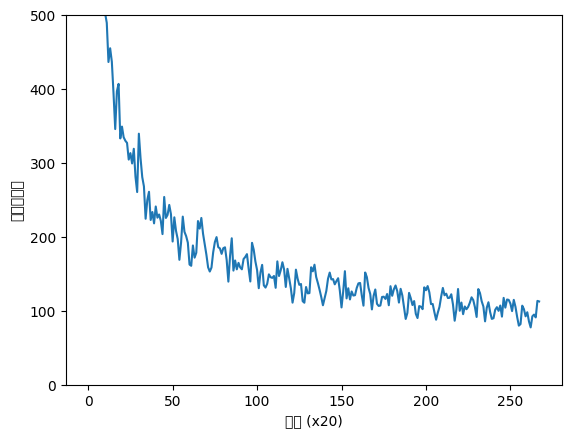

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  138.8354837606984


In [9]:
# coding: utf-8
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

### 기존의 LSTM 에서 계층 다층화 + 드롭아웃 + 가중치 공유

In [ ]:
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 세가지 개선 !
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()


In [ ]:
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)
